목표 위치: x=2.1, y=0.8
양자 최적화 시작...
Step   0 | Cost: 4.67468 | 위치: (1.61, 0.37 | 각도: (48.1, -10.2, -119.1)
Step  10 | Cost: 1.56516 | 위치: (1.11, 0.10 | 각도: (28.4, -8.9, -154.6)
Step  20 | Cost: 0.35228 | 위치: (2.05, 1.02 | 각도: (30.0, 43.7, -99.8)
Step  30 | Cost: 0.14470 | 위치: (2.22, 0.93 | 각도: (19.9, 50.2, -90.7)
Step  40 | Cost: 0.02927 | 위치: (2.12, 0.81 | 각도: (23.4, 45.9, -101.1)
Step  50 | Cost: 0.00805 | 위치: (2.04, 0.75 | 각도: (26.9, 41.2, -106.9)
Step  60 | Cost: 0.00012 | 위치: (2.12, 0.73 | 각도: (24.1, 42.5, -102.8)
Step  70 | Cost: 0.00314 | 위치: (2.13, 0.75 | 각도: (24.3, 42.1, -101.9)
Step  80 | Cost: 0.00081 | 위치: (2.09, 0.80 | 각도: (26.8, 40.7, -103.0)
Step  90 | Cost: 0.00023 | 위치: (2.10, 0.82 | 각도: (26.9, 41.0, -101.9)
Step 100 | Cost: 0.00005 | 위치: (2.10, 0.80 | 각도: (26.3, 41.1, -102.1)
Step 110 | Cost: 0.00007 | 위치: (2.10, 0.80 | 각도: (26.6, 40.8, -102.4)
Step 120 | Cost: 0.00002 | 위치: (2.10, 0.80 | 각도: (26.5, 41.0, -102.1)
Step 130 | Cost: 0.00001 | 위치: (2.10, 0.80 | 각도: (26.5, 40

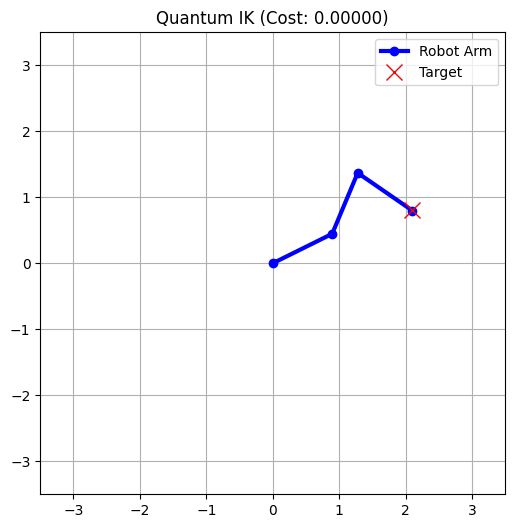

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 로봇 모델링
# ==========================================
L1 = 1.0
L2 = 1.0
L3 = 1.0
target_pos = np.array([2.1, 0.8]) 

def forward_kinematics(theta1, theta2, theta3):
    x = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2) + L3 * np.cos(theta1 + theta2 + theta3)
    y = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2) + L3 * np.sin(theta1 + theta2 + theta3)
    return np.array([x, y])

# ==========================================
# 2. 양자 회로 (3 Layers)
# ==========================================
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def robot_quantum_circuit(params):
    # Layer 1
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=1)
    qml.RX(params[4], wires=2)
    qml.RY(params[5], wires=2)
    qml.CNOT(wires=[0, 1]) # 얽힘
    qml.CNOT(wires=[1, 2])

    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RX(params[8], wires=1)
    qml.RY(params[9], wires=1)
    qml.RY(params[10], wires=2)
    qml.RY(params[11], wires=2)
    qml.CNOT(wires=[1, 0]) # 역방향 얽힘 추가
    qml.CNOT(wires=[2, 1])
    
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))]

# ==========================================
# 3. 매핑(-180 ~ 180도)
# ==========================================
def get_joint_angles(params):
    measurements = robot_quantum_circuit(params)
    
    theta1 = measurements[0] * np.pi 
    theta2 = measurements[1] * np.pi
    theta3 = measurements[2] * np.pi
    
    return theta1, theta2, theta3

def cost_function(params):
    theta1, theta2, theta3 = get_joint_angles(params)
    current_pos = forward_kinematics(theta1, theta2, theta3)
    loss = np.sum((current_pos - target_pos) ** 2)
    return loss

# ==========================================
# 4. 학습 실행
# ==========================================
params = np.random.random(12, requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.1)

print(f"목표 위치: x={target_pos[0]}, y={target_pos[1]}")
print("양자 최적화 시작...")

history = []
for i in range(150):
    params, cost = opt.step_and_cost(cost_function, params)
    history.append(cost)
    
    if i % 10 == 0:
        theta1, theta2, theta3 = get_joint_angles(params)
        curr = forward_kinematics(theta1, theta2, theta3)
        print(f"Step {i:3d} | Cost: {cost:.5f} | 위치: ({curr[0]:.2f}, {curr[1]:.2f} | 각도: ({np.degrees(theta1):.1f}, {np.degrees(theta2):.1f}, {np.degrees(theta3):.1f})")
        
    if cost == 0.0001: 
        print(f"조기 종료 (Step {i})")
        break

# ==========================================
# 5. 결과 시각화
# ==========================================
final_theta1, final_theta2, final_theta3 = get_joint_angles(params)
final_pos = forward_kinematics(final_theta1, final_theta2, final_theta3)

print(f"\n 최종 결과:")
print(f" - 관절 1: {np.degrees(final_theta1):.2f}도")
print(f" - 관절 2: {np.degrees(final_theta2):.2f}도")
print(f" - 관절 3: {np.degrees(final_theta3):.2f}도")
print(f" - 손 끝: ({final_pos[0]:.5f}, {final_pos[1]:.5f})")
print(f" - 목표와의 오차: {np.linalg.norm(final_pos - target_pos):.5f}")

plt.figure(figsize=(6,6))
x0, y0 = 0, 0
x1, y1 = L1 * np.cos(final_theta1), L1 * np.sin(final_theta1)
x2, y2 = x1 + L2 * np.cos(final_theta1 + final_theta2), y1 + L2 * np.sin(final_theta1 + final_theta2)
x3, y3 = x2 + L3 * np.cos(final_theta1 + final_theta2 + final_theta3), y2 + L3 * np.sin(final_theta1 + final_theta2 + final_theta3)

# 로봇 팔 (파란 실선)
plt.plot([x0, x1, x2, x3], [y0, y1, y2, y3], 'bo-', linewidth=3, label='Robot Arm')
# 목표 지점 (빨간 X)
plt.plot(target_pos[0], target_pos[1], 'rx', markersize=12, label='Target')
# 궤적 (있다면)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.grid(True)
plt.legend()
plt.title(f"Quantum IK (Cost: {cost:.5f})")
plt.show()